## Project and Data

This project involved utilizing a GAN in order to take real photos and change them into the style of a Monet painting. A generative adversarial network (GAN) utilizes a generator and a discriminator. The generator creates photos and the discriminator is then used to judge how well the generated images perform according to some loss function. Then, the generator updates its weights to better itself against the discriminator, while the discriminator also updates its weights to better discriminate against the generator. Thus, in this 'adversarial' way the model improves itself by continuously updating its weighs for its generator to improve against the discriminate and generate images in accordance with some purpose.

In our case, we are generating photos in the style of Monet. The data for this project involved photos of Monet paintings as well as various photographs of everyday objects. The data were provided in two formats. One was in a folder of jpg format and contained 300 photos and 7038 photos. Further, there was a provided format in the form of TFRecords. TFRecords are a storage system and which stores data as set of sequences of binary strings. This type of storage helps in terms of computational memory and performance. This is a specialized storage system which is optimized for TensorFlow. Of these TFRecords, the Monet files, have a length of 5 when read in and a length of 20. Thus, we can already see how the data scale of the data is already reduced by using TFRecords here. This data was loaded into my notebook through tf.io.gfile.glob. 

In [142]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Input, Concatenate
from keras.layers import ZeroPadding2D

In [162]:
#importing the photos as files according to tutorial kaggle recommends to use
#gets each file from monet and photo tfrec folder

# #for kaggle notebook
# from kaggle_datasets import KaggleDatasets
# path = KaggleDatasets().get_gcs_path()
# monet_files = tf.io.gfile.glob(str(path + '/monet_tfrec/*.tfrec'))
# photo_files = tf.io.gfile.glob(str(path + '/photo_tfrec/*.tfrec'))

#for local running
monet_files = tf.io.gfile.glob('/Users/sam/gan_kaggle/files/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('/Users/sam/gan_kaggle/files/photo_tfrec/*.tfrec')
print('Monet length: ', len(monet_files))
print('Photo length: ', len(photo_files))

Monet length:  5
Photo length:  20


## Data Preprocessing and Limited EDA

This was my first time working with TFRecords and thus, I utilized TensorFlow documentation on the process of reading in the data as well as a notebook suggested by Kaggle to work on this project. Both sources are listed at the bottom of this page. However, the preprocessing of the data began by setting the format with an image and image name of the TFRecords. Then, with this format, I created a function with python methods to convert data from TFRecord into photo data of size (256, 256, 3). This is done by parsing each example of the TFRecord according to the defined format. Then, it is decoded with 3 channels for RGB photos. Then, it is cast into numeric pixel versions and normalized from a scale to [1, 1]. Next, the images are reshaped into (256, 256, 3) as the initial pictures are of pixel size (256, 256) and as mentioned, we are using a RGB color scale. Lastly, I randomly flipped images in each dataset in efforts to improve model performance. With this function, the data were then loaded into a tf dataset for each batch of Monets and photos.

Next, I wanted to view the first photo in each dataset. This was performed with a function which converts each pixel value onto a scale [0,1] and then utilizes pyplot to show each image.  

In [144]:
#setting the formats, for the parser to get into tf dataset
formats = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string)
}
def tfrecord_img(instance):
    #parsing the single instance with proper format
    img_examp = tf.io.parse_single_example(instance, formats)
    img = img_examp['image']
    #decoding the image to show it is a rgb color scheme
    img_decode = tf.image.decode_jpeg(img, channels = 3)
    #casting the image pixels to float 32 and normalizing to [-1, 1]
    img_cast = (tf.cast(img_decode, tf.float32) / 127.5) - 1
    #reshaping to (256, 256, 3) for 256 256 size and 3 for channel
    img_reshape = tf.reshape(img_cast, [*[256, 256], 3])
    #randomly flipping images across the y-axis
    img_final = tf.image.random_flip_left_right(img_reshape)
    return img_final
    

#loading the data from the monet tfrec folder into a tf dataset with the applied tfrecord format
#also batching the values with a size of 1
monet_dataset = tf.data.TFRecordDataset(monet_files).map(tfrecord_img, 
                                                         num_parallel_calls=tf.data.AUTOTUNE).batch(1)
#performing the same mechanism to photos tfrec folder
photo_dataset = tf.data.TFRecordDataset(photo_files).map(tfrecord_img, 
                                                         num_parallel_calls=tf.data.AUTOTUNE).batch(1)


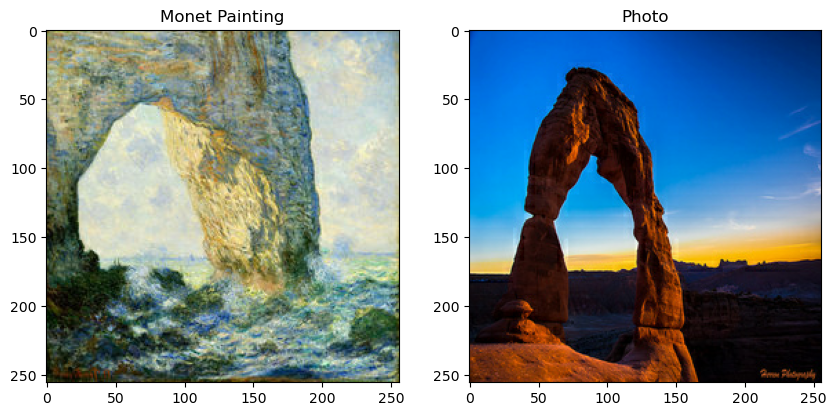

In [163]:
##printing the pictures of monet and photos

#getting the first image in both monet and photo datasets for viewing
monet_single = next((iter(monet_dataset)))
photo_single = next(iter(photo_dataset))


#plotting with plt
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 10))
#showing the first monet picture, changing pixel size [0, 1] to visualize
ax.imshow(monet_single[0] * 0.5 + .5)
ax.title.set_text('Monet Painting')
#applying same treatment to first photo
ax1.imshow(photo_single[0] * 0.5 + .5)
ax1.title.set_text('Photo')

## Functions for Modeling

Here, I am defining my functions which will be called in the model itself. First off, in the encoder (or downsampler), we are applying a keras sequential model with a to-be defined filters and size and whether to batch normalize (improving model speed). In this model, we have a convolution layer, followed by a batchnormalizer layer if argument is true, and finally we use a leaky relu layer. Then, we define our decoder (upsampler) which will be used to decode the encoded images in the GAN methodology. For the encoder we again take arguments for number of filters, the size, and here we instead take argument on whether to apply dropout layer (to improve model performance). Here; however, we start with a Convolution transpose layer. Convolution transpose layers are the opposite of convolution layers, which makes sense, since we are decoding the convolution layer of the encoder. 

In [120]:
#https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator

#encoder(downsampler)
def encoder(filters, size, apply_batchnorm=True):
    #utilizing a random normal initializer for kernel initializer in model 
    initializer = tf.random_normal_initializer(0, 0.02)
    model = Sequential()
    #adding convolution layer with stride and filters and size to be provided at later time
    model.add(Conv2D(filters, size,
                    strides=2, padding='same',
                    kernel_initializer=initializer, use_bias = False))
    #choosing when to apply batchnormalization (to improve model performance between conv and lrelu)
    if apply_batchnorm:
        model.add(BatchNormalization())
    model.add(LeakyReLU())
    return model
    
    
#decoder (upsampler)
def decoder(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0, 0.02)
    model = Sequential()
    #adding conv2d transpose layer (opposite of last conv) to decode back to normal
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    model.add(BatchNormalization())
    #adding dropout layers for certain layers when provided to improve model performance
    if apply_dropout:
        model.add(Dropout(0.7))
    model.add(ReLU())
    return model


In [121]:
#generator for the data which utilizes encoders and decoders
def Generator():
    #input layer which has images of size (256, 256, 3) due to rgb
    inputs = Input(shape=[256, 256, 3])
    #encoding the input layer by calling encoder function set times with #filters and size
    encoders = [
        encoder(64, 4, apply_batchnorm=False),
        encoder(128, 4),
        encoder(128, 4),
        encoder(128, 4),
        encoder(128, 4),
        encoder(256, 4),
        encoder(256, 4),
        encoder(256, 4)
    ]
    #decoding the output from the encoders calling decoder function with #filters and size
    decoders = [
        decoder(256, 4, apply_dropout=True),
        decoder(256, 4, apply_dropout=True),
        decoder(256, 4, apply_dropout=True),
        decoder(256, 4),
        decoder(128, 4),
        decoder(128, 4),
        decoder(64, 4)
    ]
    initializer = tf.random_normal_initializer(0, 0.02)
    #final layer of decoder which adds conv2d with 3 fitlers and tanh to get back to proper channels
    ##we see we have same number of encoder layers as decoder layers
    final = Conv2DTranspose(3, 4, strides = 2, padding = 'same', kernel_initializer=initializer,
                          activation = 'tanh')
    #taking each input and running it through each encoder instances
    vals = inputs
    skips = []
    for down in encoders:
        vals = down(vals)
        skips.append(vals)
    #reversing and going through decoders
    skips = reversed(skips[:-1])
    
    for up, skip in zip(decoders, skips):
        vals = up(vals)
        vals = Concatenate()([vals, skip])
    vals = final(vals)
    #thus, runs through eno
    return tf.keras.Model(inputs=inputs, outputs=vals)

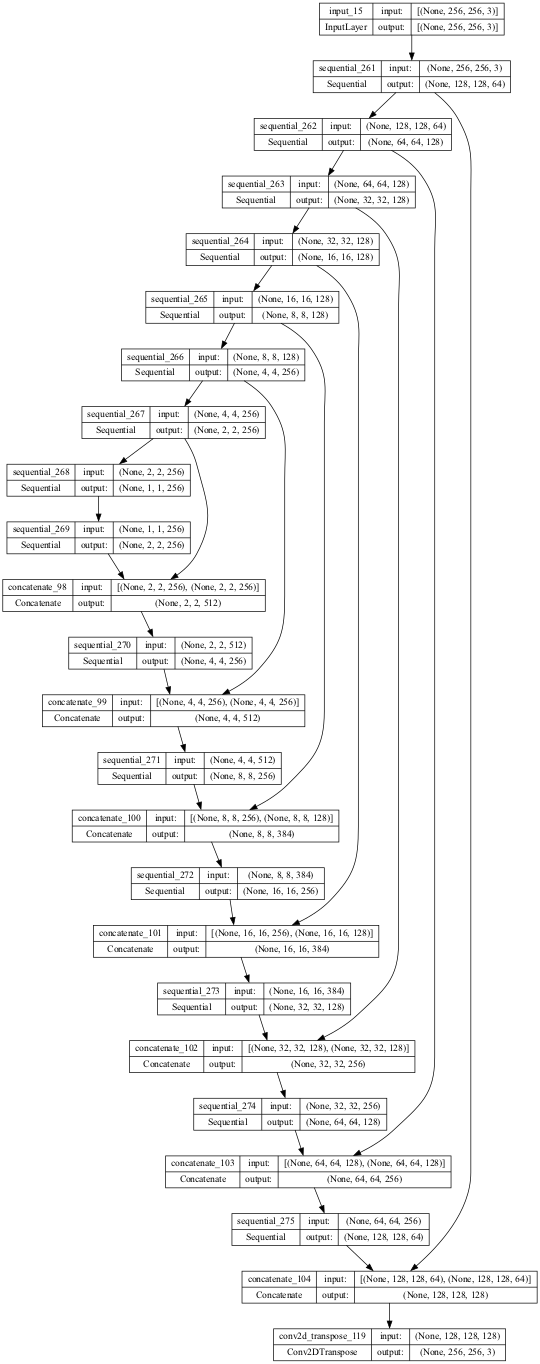

In [122]:
#visualizes the generation process of encoding and decoding
tf.keras.utils.plot_model(Generator(), show_shapes=True, dpi=50)

In [123]:
#discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    #initial input to discriminators
    inputs = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    vals = inputs
    #running through 3 encoders, building upon last encoding
    encode_1 = encoder(64, 4, False)(vals)  
    encode_2 = encoder(128, 4)(encode_1)  
    encode_3 = encoder(256, 4)(encode_2) 
    #padding with zeros to encoded data
    zero_pad_1 = ZeroPadding2D()(encode_3) 
    #conv layer
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad_1) 

    batchnorm_1 = BatchNormalization()(conv)

    leaky_relu = LeakyReLU()(batchnorm_1)
    #padding again
    zero_pad_2 = ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
    #final convolution layer
    final = Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad_2)  # (batch_size, 30, 30, 1)
    #returing discriminator as model
    return tf.keras.Model(inputs=vals, outputs=final)


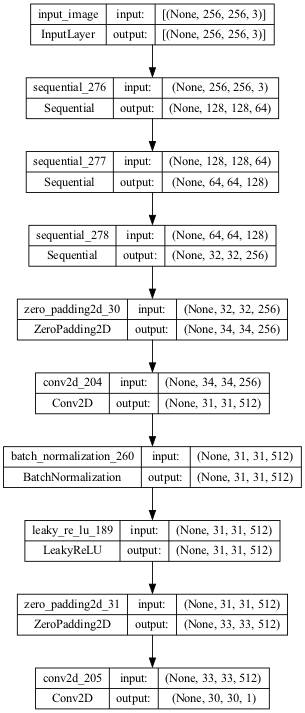

In [124]:
#visualizing discriminator 
tf.keras.utils.plot_model(Discriminator(), show_shapes=True, dpi=64)

In [125]:
#setting generator and discriminator for monet and photo
#applying generator and discriminators for each photo and monet
generate_monet = Generator()
generate_photo = Generator()
discriminate_monet = Discriminator()
discriminate_photo = Discriminator()

#using adam as optimizer with learning rate 0.0002 and beta of 0.5
#utilizing legacy version of Adam as due to my tf version, legacy optimizer is needed to run
adam = tf.keras.optimizers.legacy.Adam(0.0002, beta_1=0.5)
#setting optimizers for each generation and discrimination of monet and photo
generate_monet_opt = adam
generate_photo_opt = adam
discriminate_monet_opt = adam
discriminate_photo_opt = adam

In [126]:
#show what initial iteration of generating from monet and photo looks like
def generate_images(model, test_input):
    #getting predicted image from provided input
    prediction = model(test_input, training=True)
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    ax1.imshow(display_list[0] * 0.5 + 0.5)
    ax2.imshow(display_list[1] * 0.5 + 0.5)
    ax1.title.set_text(title[0])
    ax2.title.set_text(title[1])
    plt.show()

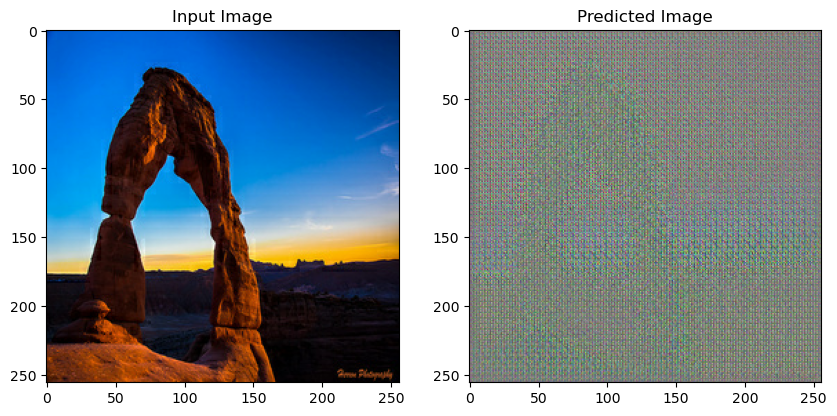

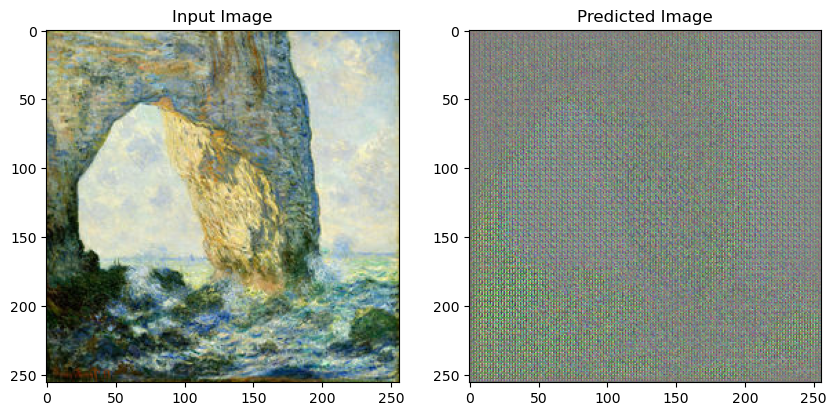

In [127]:
#generate monet from photo
for example_input in photo_dataset.take(1):
    generate_images(generate_monet, example_input)
#generate photo from monet
for example_input in monet_dataset.take(1):
    generate_images(generate_photo, example_input)

In [112]:
#building loss function for our discriminator
def discriminator_loss(real_image, generated_image):
    #using binary cross entropy as mentioned in lecture
    #loss looking at real images
    loss_for_real = tf.keras.losses.BinaryCrossentropy(from_logits = True)(tf.ones_like(real_image), real_image)
    #loss looking at generated images
    loss_for_generated = tf.keras.losses.BinaryCrossentropy(from_logits = True)(tf.zeros_like(generated_image), generated_image)
    total_loss_for_discriminator = loss_for_generated + loss_for_real
    return total_loss_for_discriminator * 0.5
#building loss function for generator
def generator_loss(generated_image):
    return tf.keras.losses.BinaryCrossentropy(from_logits = True)(tf.ones_like(generated_image), generated_image)

#utilizing cycle consistency, put this in write up
def cycle_loss(real_image, cycled_image):
    #getting los between real images and cycle image
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss

#utilizing identity loss, put in write up
def identity_loss(real_image, same_real_image):
    #loss of real image and the generation to appear as same as this image
    loss = tf.reduce_mean(tf.abs(real_image - same_real_image))
    return 10 * loss * 0.5

In [131]:
#building the cycle gan from defined functions above
class CycleGan(tf.keras.Model):
    #defining what arguments model will accept, here taking generators and discriminators
    def __init__(
        self,
        generate_monet,
        generate_photo,
        discriminate_monet,
        discriminate_photo
    ):
        #followed operations from #https://keras.io/examples/generative/cyclegan/ here
        super(CycleGan, self).__init__()
        #setting each generator and discriminator to be used throughout class
        self.generate_monet = generate_monet
        self.generate_photo = generate_photo
        self.discriminate_monet = discriminate_monet
        self.discriminate_photo = discriminate_photo
    #compiling the model and selecting input of optimizers and loss functions
    def compile(self,
        generate_monet_opt,
        generate_photo_opt,
        discriminate_monet_opt,
        discriminate_photo_opt,
        geneator_loss,
        discriminator_loss,
        cycle_loss,
        idnetity_loss
        
    ):
        super(CycleGan, self).compile()
        #setting optimizers and loss functions to be used for later instances in class
        self.model_generate_monet_opt = generate_monet_opt
        self.model_generate_photo_opt = generate_photo_opt
        self.model_discriminate_monet_opt = discriminate_monet_opt
        self.model_discriminate_photo_opt = discriminate_photo_opt
        self.model_generator_loss = generator_loss
        self.model_discriminator_loss = discriminator_loss
        self.model_cycle_loss = cycle_loss
        self.model_identity_loss = identity_loss
        
    
    #function that trains model  
    def train_step(self, input_data):
        #getting monet and photo which will be provided to model
        real_monet, real_photo = input_data
        #using GradientTape in accordance with https://www.tensorflow.org/tutorials/generative/cyclegan
        with tf.GradientTape(persistent=True) as tape:
            #generating monet from photo
            fake_monet = self.generate_monet(real_photo, training=True)
            #generating photo from monet
            fake_photo = self.generate_photo(real_monet, training=True)
            #generating cycle photo from the fake monet generated above
            cycle_photo = self.generate_photo(fake_monet, training=True)
            #generating cycle monet from the fake photo generated above
            cycle_monet = self.generate_monet(fake_photo, training=True)
            
            #generating monet from real monet
            same_monet = self.generate_monet(real_monet, training=True)
            #generating photo from real photo 
            same_photo = self.generate_photo(real_photo, training=True)
            
            #discriminating monet against the real monet
            real_monet_discriminate = self.discriminate_monet(real_monet, training=True)
            #discriminating monet againt fake monet
            fake_monet_discriminate = self.discriminate_monet(fake_monet, training=True)
            #discriminating photo from real photo
            real_photo_discriminate = self.discriminate_photo(real_photo, training=True)
            #discriminating photo from fake photo
            fake_photo_discriminate = self.discriminate_photo(fake_photo, training=True)
            
            #getting gneerated loss from fake monet and photo discriminators
            loss_generated_monet = self.model_generator_loss(fake_monet_discriminate)
            loss_generated_photo = self.model_generator_loss(fake_photo_discriminate)
            
            #getting cycle loss from real monet photo and cycled monety and photo
            loss_cycled = self.model_cycle_loss(real_monet, cycle_monet)
            loss_cycled += self.model_cycle_loss(real_photo, cycle_photo)
            
            #getting loss when looking at monet and photo and corresponding gneerations of each
            loss_monet_same = self.model_identity_loss(real_monet, same_monet)
            loss_photo_same = self.model_identity_loss(real_photo, same_photo)
            
            #adding total loss for both monet and photo
            total_loss_generated_monet = loss_generated_monet + loss_cycled + loss_monet_same
            total_loss_generated_photo = loss_generated_photo + loss_cycled + loss_photo_same
            
            #getting discriminator loss for monet and photo from earlier discriminator on monet and photo
            loss_discriminator_monet = self.model_discriminator_loss(real_monet_discriminate, fake_monet_discriminate)
            loss_discriminator_photo = self.model_discriminator_loss(real_photo_discriminate, fake_photo_discriminate)
            
            
        #setting the gradients for generator from GradientTape https://www.tensorflow.org/tutorials/generative/cyclegan
        generator_monet_gradients = tape.gradient(total_loss_generated_monet, self.generate_monet.trainable_variables)
        generator_photo_gradients = tape.gradient(total_loss_generated_photo, self.generate_photo.trainable_variables)
        
        #setting the gradients for discriminator from Gradient Tape 
        discriminator_monet_gradients = tape.gradient(loss_discriminator_monet, self.discriminate_monet.trainable_variables)
        discriminator_photo_gradients = tape.gradient(loss_discriminator_photo, self.discriminate_photo.trainable_variables)
        #applying gradients to the initial provided optimizers
        #gradients for generate and discriminate of monet and photo as well as trainable variables
        self.model_generate_monet_opt.apply_gradients(
            zip(generator_monet_gradients, self.generate_monet.trainable_variables)
        )
        self.model_generate_photo_opt.apply_gradients(
            zip(generator_photo_gradients, self.generate_photo.trainable_variables)
        )
        self.model_discriminate_monet_opt.apply_gradients(
            zip(discriminator_monet_gradients, self.discriminate_monet.trainable_variables)
        )
        self.model_discriminate_photo_opt.apply_gradients(
            zip(discriminator_photo_gradients, self.discriminate_photo.trainable_variables)
        )
        #returns the loss associated with each generator and discriminator
        return {
            'generator_monet_loss': total_loss_generated_monet,
            'generator_photo_loss': total_loss_generated_photo,
            'discriminator_monet_loss': loss_discriminator_monet,
            'discriminator_photo_loss': loss_discriminator_photo
        }

In [132]:
#creating our CycleGan and providing generators and discriminators
cycle_gan = CycleGan(
    generate_monet, generate_photo, discriminate_monet, discriminate_photo
)
#compiling gan with optimizers and loss functions
cycle_gan.compile(
    generate_monet_opt,
    generate_photo_opt,
    discriminate_monet_opt,
    discriminate_photo_opt,
    generator_loss,
    discriminator_loss,
    cycle_loss,
    identity_loss
)

In [ ]:
#model score on kaggle 684.06252

#fitting model on both datasets and going through 10 epochs here
cycle_gan.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=10
)

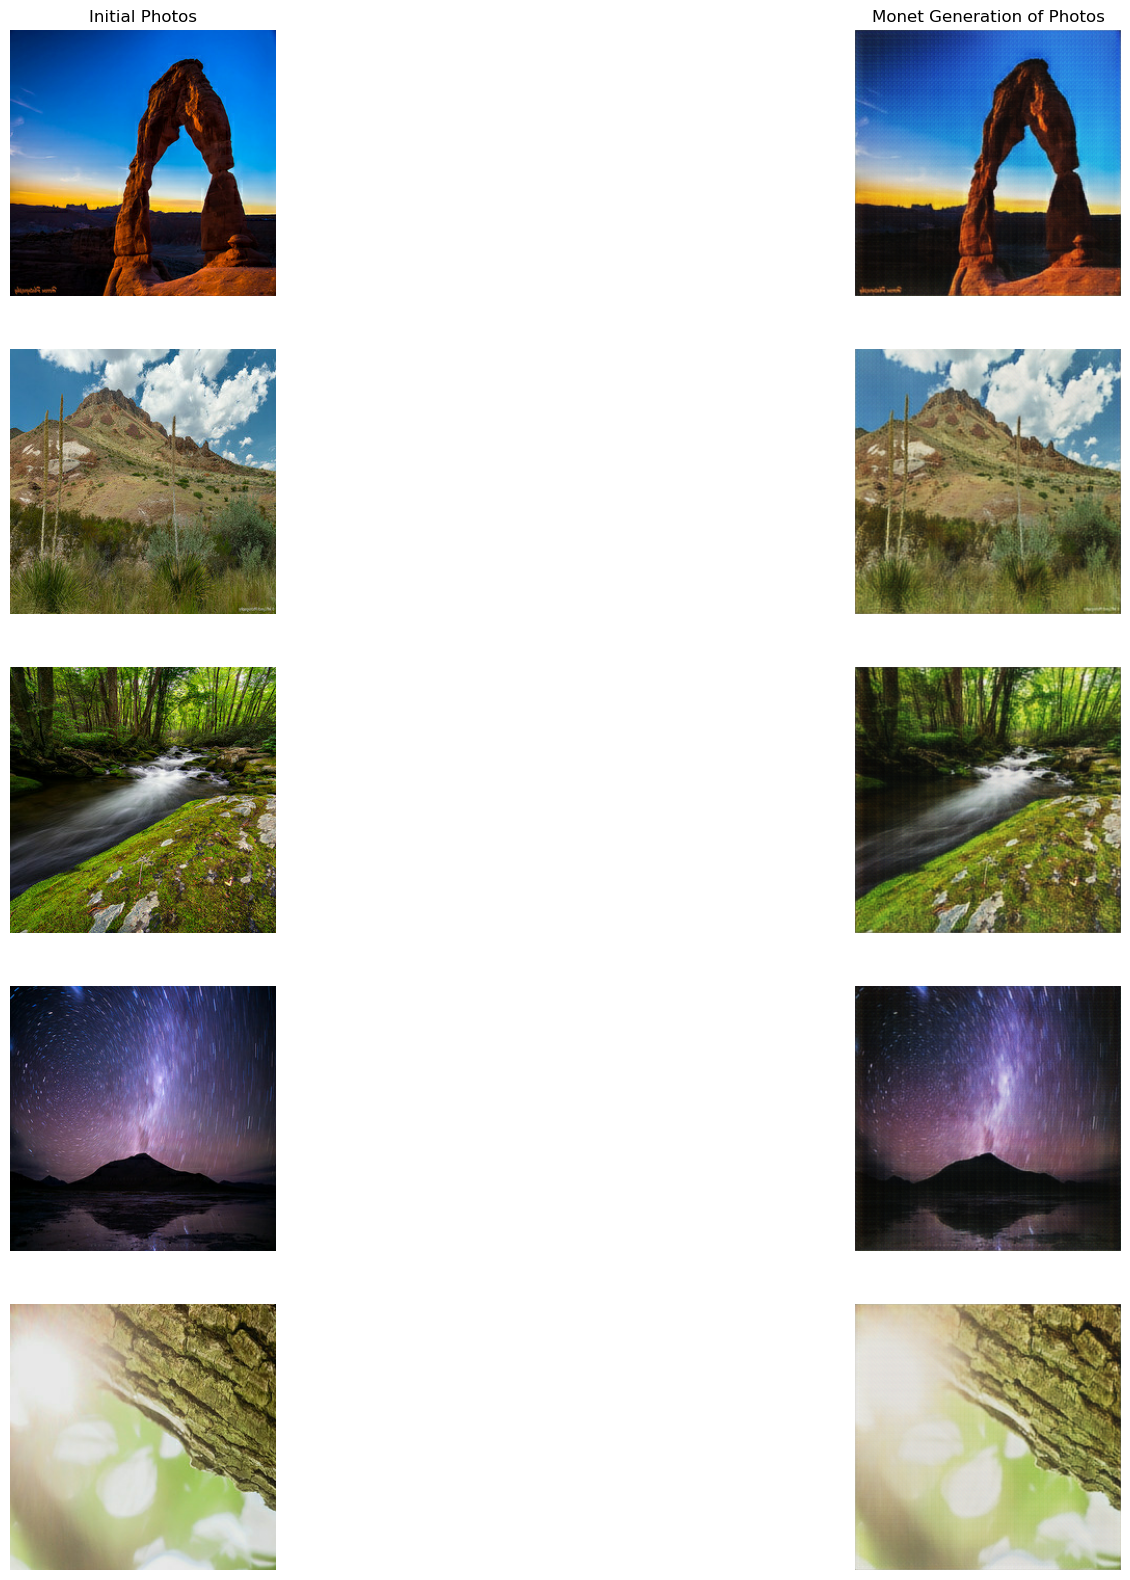

In [159]:
#Visualizing the model's monet of photos
fig, ax = plt.subplots(5, 2, figsize=(20,20))
ax[0, 0].set_title('Initial Photos')
ax[0, 1].set_title('Monet Generation of Photos')
for i, img in enumerate(photo_dataset.take(5)):
    predict = generate_monet(img, training=False)[0].numpy()
    predict = (predict * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(predict)
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.show()

In [164]:
##Second model with improved hyperparameters

#generator for the data which utilizes encoders and decoders
def Generator():
    #input layer which has images of size (256, 256, 3) due to rgb
    inputs = Input(shape=[256, 256, 3])
    #encoding the input layer by calling encoder function set times with #filters and size
    encoders = [
        encoder(64, 4, apply_batchnorm=False),
        encoder(256, 4),
        encoder(256, 4),
        encoder(256, 4),
        encoder(512, 4),
        encoder(512, 4),
        encoder(512, 4),
        encoder(512, 4)
    ]
    #decoding the output from the encoders calling decoder function with #filters and size
    decoders = [
        decoder(512, 4, apply_dropout=True),
        decoder(512, 4, apply_dropout=True),
        decoder(512, 4, apply_dropout=True),
        decoder(256, 4),
        decoder(256, 4),
        decoder(128, 4),
        decoder(64, 4)
    ]
    initializer = tf.random_normal_initializer(0, 0.02)
    #final layer of decoder which adds conv2d with 3 fitlers and tanh to get back to proper channels
    ##we see we have same number of encoder layers as decoder layers
    final = Conv2DTranspose(3, 4, strides = 2, padding = 'same', kernel_initializer=initializer,
                          activation = 'tanh')
    #taking each input and running it through each encoder instances
    vals = inputs
    skips = []
    for down in encoders:
        vals = down(vals)
        skips.append(vals)
    #reversing and going through decoders
    skips = reversed(skips[:-1])
    
    for up, skip in zip(decoders, skips):
        vals = up(vals)
        vals = Concatenate()([vals, skip])
    vals = final(vals)
    #thus, runs through eno
    return tf.keras.Model(inputs=inputs, outputs=vals)

In [165]:
def decoder(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0, 0.02)
    model = Sequential()
    #adding conv2d transpose layer (opposite of last conv) to decode back to normal
    model.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    model.add(BatchNormalization())
    #adding dropout layers for certain layers when provided to improve model performance
    if apply_dropout:
        model.add(Dropout(0.4))
    model.add(ReLU())
    return model

In [ ]:
#creating our CycleGan and providing generators and discriminators
cycle_gan = CycleGan(
    generate_monet, generate_photo, discriminate_monet, discriminate_photo
)
#compiling gan with optimizers and loss functions
cycle_gan.compile(
    generate_monet_opt,
    generate_photo_opt,
    discriminate_monet_opt,
    discriminate_photo_opt,
    generator_loss,
    discriminator_loss,
    cycle_loss,
    identity_loss
)


#fitting model on both datasets and going through 10 epochs here
cycle_gan.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=10
)

Epoch 1/10


2023-03-05 21:31:27.133619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 89s 266ms/step - generator_monet_loss: 2.6531 - generator_photo_loss: 2.7286 - discriminator_monet_loss: 0.6397 - discriminator_photo_loss: 0.6222
Epoch 2/10
300/300 [==============================] - 73s 244ms/step - generator_monet_loss: 2.6327 - generator_photo_loss: 2.7149 - discriminator_monet_loss: 0.6392 - discriminator_photo_loss: 0.6186
Epoch 3/10
300/300 [==============================] - 73s 244ms/step - generator_monet_loss: 2.6116 - generator_photo_loss: 2.6980 - discriminator_monet_loss: 0.6393 - discriminator_photo_loss: 0.6173
Epoch 4/10
300/300 [==============================] - 73s 244ms/step - generator_monet_loss: 2.6030 - generator_photo_loss: 2.6934 - discriminator_monet_loss: 0.6358 - discriminator_photo_loss: 0.6146
Epoch 5/10
300/300 [==============================] - 73s 245ms/step - generator_monet_loss: 2.5800 - generator_photo_loss: 2.6762 - discriminator_monet_loss: 0.6412 - discriminator_photo_loss: 0.6152
Epoch 

In [141]:
# creating prediction zip according to 
# https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook#Visualize-our-Monet-esque-photos

# making a directory for images
import PIL
! mkdir ../gan_kaggle/images

#predicting for each photo
val = 1
for img in photo_dataset:
    predict = generate_monet(img, training=False)[0].numpy()
    predict = (predict * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(predict)
    val += 1

import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")


# from io import BytesIO
# from PIL import Image
# from zipfile import ZipFile

# with ZipFile('images.zip', mode='w') as zip_f:
#     val = 1
#     for img in photo_dataset:
#         predict = generate_monet(img, training=False)[0].numpy()
#         predict = (predict * 127.5 + 127.5).astype(np.uint8)
#         with BytesIO() as image_byte:
#             Image.fromarray(predict).save(image_byte, 'JPEG')
#             image_byte.seek(0)
#             zip_f.writestr('{}.jpg'.format(val), image_byte.read())
#             val += 1


Sources: 

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

https://www.tensorflow.org/tutorials/load_data/tfrecord

https://www.tensorflow.org/tutorials/generative/cyclegan

https://www.kaggle.com/code/zahid0/gan-tensorflow

https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator

https://keras.io/examples/generative/cyclegan/

https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564